In [17]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open("certcards2.txt", mode="r", encoding="utf8") as f:
    all_cards = f.read()

card_split_pattern = r"\n\n\n\d+\n"
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r"(.+?)\n([\s\S]+)", re.DOTALL)
cards = [
    (match.group(1), match.group(2))
    for cstring in all_cards
    if (match := re.search(card_pattern, cstring))
]

# removing the cards that have no content and trimming
cards = [
    (subject, stripped_content)
    for subject, content in cards
    if len(stripped_content := content.strip()) > 5
]


def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode("utf-8")).hexdigest()


def remake_card_document(
    existing_cards: pd.DataFrame, filename: str = "certcards2.txt"
):
    with open(filename, mode="w", encoding="utf8") as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write("\n" * 6)
            f.write(str(i) + "\n")
            f.write(row["head"] + "\n")
            f.write(row["body"])
            i += 1
    print(f"Cards found: {existing_cards.shape[0]}")
    print(f"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=["head", "body"])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards["hash"] = existing_cards["body"].apply(hash_string_md5)

card_ages = pd.read_json("card_ages.json")
card_ages = card_ages.drop_duplicates(subset=["hash"], keep="first")

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[["hash", "age"]],
    left_on="hash",
    right_on="hash",
    how="left",
)


cards_to_age["head"] = cards_to_age["head"].str.strip()

# remove headers I don't want anymore
undesired_headers = ["CCH Axcess"]
cards_to_age = cards_to_age.loc[~cards_to_age["head"].isin(undesired_headers), :].copy()

cards_to_age["age"] = cards_to_age["age"].fillna(0)

age_factor = 1.01
cards_to_age["age"] = cards_to_age["age"] * age_factor

cards_to_age["age"] = cards_to_age["age"] + [
    random.expovariate(0.5) for _ in cards_to_age.index
]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
mean = cards_to_age["age"].mean()
threshold = .005+(mean/1000)
shuffle_role = random.random()
print(f"{shuffle_role=}; {threshold=}")
if shuffle_role < threshold:
    cards_to_age["age"] = cards_to_age["age"] * [
        random.expovariate(1.3) for _ in cards_to_age.index
    ]

# Adding priority age growth to cards for upcoming certifications
priority_headers = [
    "Django", 
    "Python + Oauth2.0"
    ]
priority_cards_mask = cards_to_age["head"].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, "age"] = (
    cards_to_age.loc[priority_cards_mask, "age"] * 1.0718
)

cards_to_age = cards_to_age.drop_duplicates(subset=["hash"], keep="first")

cards_to_age["subject_mean_age"] = cards_to_age.groupby("head")["age"].transform("mean")
cards_to_age["subject_highest_age"] = cards_to_age.groupby("head")["age"].transform(
    "max"
)
cards_to_age["subject_age_sum"] = cards_to_age.groupby("head")["age"].transform("sum")
cards_to_age["head_random_roll"] = cards_to_age.groupby("head")["head"].transform(
    lambda x: random.random()
)
cards_to_age["head_count"] = cards_to_age.groupby("head")["head"].transform("count")


cards_to_age.sort_values("hash")[["age", "head", "hash"]].to_json(
    "card_ages.json", indent=2
)

existing_cards = cards_to_age

In [ ]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Ubuntu,366.824206,14.108623,63.982955,26
eDiscovery,777.821893,14.404109,78.447362,54
Network Terms,249.926848,16.661790,37.144879,15
TSQL,50.680256,16.893419,22.168867,3
GUI Docker Container,428.032809,20.382515,49.006247,21
SSH + SCP,627.954802,21.653614,98.665186,29
Exchange Online and Defender,896.957818,22.998918,72.628874,39
"The Mines of the Behemoth, Shea",1311.326760,26.761771,123.902231,49
"Everything is Tuberculosis, Green",727.071523,31.611805,194.240153,23
Power BI,317.469218,39.683652,123.277989,8


# Histogram

sum of ages: ~40513.46


<Axes: >

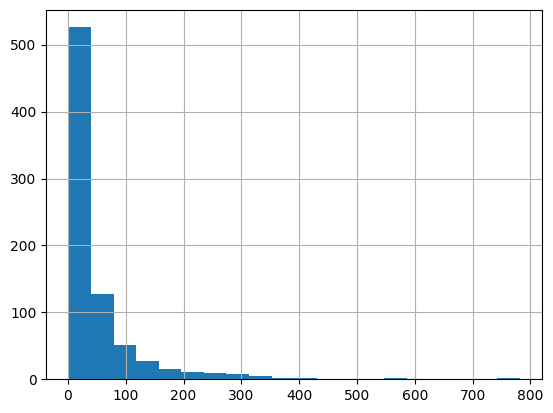

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~40513.46


<Axes: >

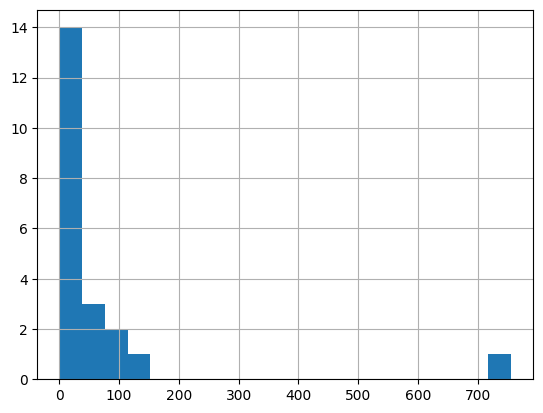

In [21]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='WinHex']['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [ ]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

Cards found: 790
Total card age: 40513.46


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Microsoft Purview,"The technical metadata includes schema, data t...",e075b6e051b56bf4339683cc14994184,781.163942,94.481939,781.163942,3779.277554,0.314923,40
5,WinHex,Advanced Adjacent Terms\nZoned Bit Recording (...,6c188d655123f654671ddbe9e25ee8b3,755.311655,67.605884,755.311655,1419.723556,0.406233,21
10,Node.js and Vite,Debugger attached\nA message from Node when ru...,128567e0fcdb7e5c074de0dc7ff33928,613.280088,83.242178,613.280088,2913.476240,0.326124,35
11,Node.js and Vite,"""Unexpected token"" (Babel error)\nJS syntax er...",9c8d82516fc972a6c5b042007d3943a8,585.307404,83.242178,613.280088,2913.476240,0.326124,35
15,Terraform Codebox,corepack enable\nA command that activates Core...,dbbb73cbfd843df20879274cb633c9ac,573.833697,76.086723,573.833697,2434.775148,0.064681,32
20,"Mexican Gothic, Moreno-Garcia","trousseau (troo-SOH)\nnoun\nThe clothes, linen...",e68146db262d468ec9bc38f4439717a0,439.532224,62.875913,439.532224,1446.146003,0.125375,23
25,Python + Oauth2.0,handler.wfile.write()\n\nWrites a response bac...,0a49706ef2305810297830c1b5b23dc6,415.213725,124.259958,415.213725,1988.159332,0.326450,16
26,Python + Oauth2.0,urllib.parse.urlencode()\n\nEncodes a dictiona...,a6a4fec4f5f3154e2890a09a3ec81636,394.990377,124.259958,415.213725,1988.159332,0.326450,16
1,Microsoft Purview,The most effective end-user documentation will...,cd14ee472435ecdf15fed24da734eca3,364.316957,94.481939,781.163942,3779.277554,0.314923,40
16,Terraform Codebox,"In Windows PowerShell, RSA SSH keys can be gen...",51fc9593224fc39fc8e432d6be5db48e,357.343829,76.086723,573.833697,2434.775148,0.064681,32


# N-fold shuffle


## Age Sum

In [24]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [25]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [26]:
# n = random.choice([2, 3, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [ ]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)


## Random

In [28]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [29]:
existing_cards.head(10)['age'].sum()

np.float64(5280.293898677919)

In [30]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count
0,Microsoft Purview,"The technical metadata includes schema, data t...",e075b6e051b56bf4339683cc14994184,781.163942,94.481939,781.163942,3779.277554,0.314923,40
5,WinHex,Advanced Adjacent Terms\nZoned Bit Recording (...,6c188d655123f654671ddbe9e25ee8b3,755.311655,67.605884,755.311655,1419.723556,0.406233,21
10,Node.js and Vite,Debugger attached\nA message from Node when ru...,128567e0fcdb7e5c074de0dc7ff33928,613.280088,83.242178,613.280088,2913.476240,0.326124,35
11,Node.js and Vite,"""Unexpected token"" (Babel error)\nJS syntax er...",9c8d82516fc972a6c5b042007d3943a8,585.307404,83.242178,613.280088,2913.476240,0.326124,35
15,Terraform Codebox,corepack enable\nA command that activates Core...,dbbb73cbfd843df20879274cb633c9ac,573.833697,76.086723,573.833697,2434.775148,0.064681,32
20,"Mexican Gothic, Moreno-Garcia","trousseau (troo-SOH)\nnoun\nThe clothes, linen...",e68146db262d468ec9bc38f4439717a0,439.532224,62.875913,439.532224,1446.146003,0.125375,23
25,Python + Oauth2.0,handler.wfile.write()\n\nWrites a response bac...,0a49706ef2305810297830c1b5b23dc6,415.213725,124.259958,415.213725,1988.159332,0.326450,16
26,Python + Oauth2.0,urllib.parse.urlencode()\n\nEncodes a dictiona...,a6a4fec4f5f3154e2890a09a3ec81636,394.990377,124.259958,415.213725,1988.159332,0.326450,16
1,Microsoft Purview,The most effective end-user documentation will...,cd14ee472435ecdf15fed24da734eca3,364.316957,94.481939,781.163942,3779.277554,0.314923,40
16,Terraform Codebox,"In Windows PowerShell, RSA SSH keys can be gen...",51fc9593224fc39fc8e432d6be5db48e,357.343829,76.086723,573.833697,2434.775148,0.064681,32


In [31]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 51.283'